##$ Different meshes are available when solving the diffusion or any other PDE

For a 1D system, the diffusional flux is defined as

$ J = -D \frac{\partial x}{\partial z} $

**Cartesian**

$ \frac{\partial x}{\partial t} = -\frac{\partial}{\partial z} (J) $

**Cylindrical**

$ \frac{\partial x}{\partial t} = - \frac{1}{r} \frac{\partial}{\partial r} (r J) $

**Spherical**

$ \frac{\partial x}{\partial t} = - \frac{1}{r^2} \frac{\partial}{\partial r} (r^2 J) $

To show the different meshes, we could create a simple diffusion model to apply the meshes to and compare to analytical solutions

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from kawin.GenericModel import GenericModel

class CustomModel(GenericModel):
    def __init__(self, mesh, D = 1):
        super().__init__()
        self.mesh = mesh
        self.D = D

    def getCurrentX(self):
        return [self.mesh.y]
    
    def getDt(self, dxdt):
        return 0.4*np.amin(self.mesh.dz)**2 / self.D
    
    def getdXdt(self, t, x):
        y, z = self.mesh.getDiffusivityCoordinates(x[0])
        Ds = self.D*np.ones(y.shape)
        y, z = self.mesh.getResponseCoordinates(x[0])
        return [self.mesh.computedXdt([(Ds, y)])]
    
    def postProcess(self, time, x):
        super().postProcess(time, x)
        self.mesh.y = x[0]
        return self.getCurrentX(), False
    

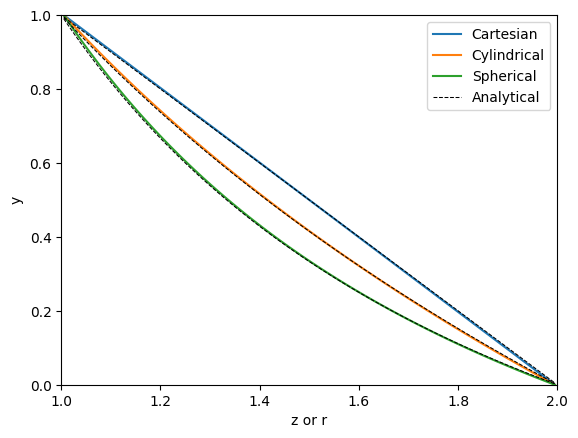

In [6]:
from kawin.diffusion.mesh import Cartesian1D, Cylindrical1D, Spherical1D, MixedBoundary1D, ProfileBuilder

limits = [1, 2]
N = 100
dims = 1

# Dirichlet boundary conditions on ends of mesh
bc = MixedBoundary1D(dims)
bc.setLBC(0, 'dirichlet', 1)
bc.setRBC(0, 'dirichlet', 0)

profile = ProfileBuilder()

meshCartesian = Cartesian1D(dims, limits, N)
meshCylindrical = Cylindrical1D(dims, limits, N)
meshSpherical = Spherical1D(dims, limits, N)
meshes = [meshCartesian, meshCylindrical, meshSpherical]
labels = ['Cartesian', 'Cylindrical', 'Spherical']
for i, mesh in enumerate(meshes):
    mesh.setResponseProfile(profile, bc)
    model = CustomModel(mesh, D=1)
    model.solve(1)
    plt.plot(mesh.z, mesh.y, label=labels[i])

# Solution for cartesian: x = A*z + B
# Solution for cylindrical: x = A*ln(r) + B
# Solution for spherical: x = A/r + B
cart_ideal = -1*meshCartesian.z + 2
cyl_ideal = -np.log(meshCylindrical.z)/np.log(2) + 1
sph_ideal = 2/meshSpherical.z - 1
plt.plot(meshCartesian.z, cart_ideal, color='k', linestyle='--', linewidth=0.75, label='Analytical')
plt.plot(meshCylindrical.z, cyl_ideal, color='k', linestyle='--', linewidth=0.75, label='Analytical')
plt.plot(meshSpherical.z, sph_ideal, color='k', linestyle='--', linewidth=0.75, label='Analytical')
plt.xlim([1,2])
plt.ylim([0,1])
plt.xlabel('z or r')
plt.ylabel('y')
plt.legend(labels=labels+['Analytical'])
plt.show()

Periodic boundary conditions are also available, but is only valid for cartesian meshes

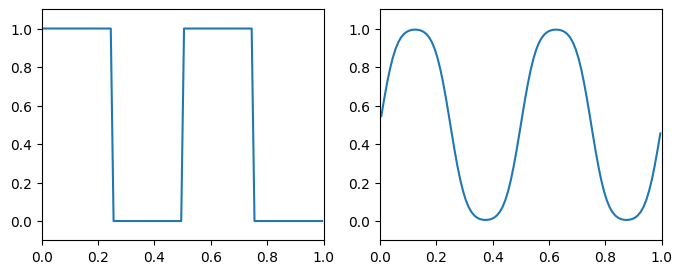

In [9]:
from kawin.diffusion.mesh import PeriodicBoundary1D, BoundedRectangleProfile

profile = ProfileBuilder()
profile.addBuildStep(BoundedRectangleProfile(0, 0.25, 1, 0))
profile.addBuildStep(BoundedRectangleProfile(0.5, 0.75, 1, 0))

pb = PeriodicBoundary1D()
mesh = Cartesian1D(responses=1, zlim=[0,1], N=100)
mesh.setResponseProfile(profile, pb)

fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].plot(mesh.z, mesh.y)
ax[0].set_xlim([0,1])
ax[0].set_ylim([-0.1, 1.1])

model = CustomModel(mesh, D=1)
model.solve(1e-3)
ax[1].plot(mesh.z, mesh.y)
ax[1].set_xlim([0,1])
ax[1].set_ylim([-0.1, 1.1])
plt.show()